In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import joblib
from sklearn.metrics import r2_score

path = 'dataset'
trainPath = os.path.join(path, 'train.csv')
testPath = os.path.join(path, 'test.csv')
outPath = 'out'
modelPath = 'model'

train = pd.read_csv(trainPath)
test = pd.read_csv(testPath)
sample = pd.read_csv(os.path.join(path, 'sample_submission.csv'))

def outCsv(sample, fileName):
    sample.to_csv(os.path.join(outPath, fileName), index=False)

def outModel(model, fileName):
    joblib.dump(model, os.path.join(modelPath, fileName))

### 数据探索

In [3]:
print(train.columns)
print(train.columns.shape)
feature = train.drop(columns=['id', 'FloodProbability']).columns

Index(['id', 'MonsoonIntensity', 'TopographyDrainage', 'RiverManagement',
       'Deforestation', 'Urbanization', 'ClimateChange', 'DamsQuality',
       'Siltation', 'AgriculturalPractices', 'Encroachments',
       'IneffectiveDisasterPreparedness', 'DrainageSystems',
       'CoastalVulnerability', 'Landslides', 'Watersheds',
       'DeterioratingInfrastructure', 'PopulationScore', 'WetlandLoss',
       'InadequatePlanning', 'PoliticalFactors', 'FloodProbability'],
      dtype='object')
(22,)


In [4]:
feature.shape

(20,)

In [5]:
print('train set null values: ', train.isnull().any().sum())
print('test set null values: ', test.isnull().any().sum())

train set null values:  0
test set null values:  0


In [6]:
print(train.shape)
print(test.shape)

(1117957, 22)
(745305, 21)


In [7]:
train.describe()

,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
count,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,...,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06
mean,5.589780e+05,4.921450e+00,4.926671e+00,4.955322e+00,4.942240e+00,4.942517e+00,4.934093e+00,4.955878e+00,4.927791e+00,4.942619e+00,...,4.946893e+00,4.953999e+00,4.931376e+00,4.929032e+00,4.925907e+00,4.927520e+00,4.950859e+00,4.940587e+00,4.939004e+00,5.044803e-01
std,3.227265e+05,2.056387e+00,2.093879e+00,2.072186e+00,2.051689e+00,2.083391e+00,2.057742e+00,2.083063e+00,2.065992e+00,2.068545e+00,...,2.072333e+00,2.088899e+00,2.078287e+00,2.082395e+00,2.064813e+00,2.074176e+00,2.068696e+00,2.081123e+00,2.090350e+00,5.102610e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.850000e-01
25%,2.794890e+05,3.000000e+00,3.000000e+00,4.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,...,4.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,4.700000e-01
50%,5.589780e+05,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,...,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.050000e-01
75%,8.384670e+05,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,...,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,5.400000e-01
max,1.117956e+06,1.600000e+01,1.800000e+01,1.600000e+01,1.700000e+01,1.700000e+01,1.700000e+01,1.600000e+01,1.600000e+01,1.600000e+01,...,1.700000e+01,1.700000e+01,1.600000e+01,1.600000e+01,1.700000e+01,1.800000e+01,1.900000e+01,1.600000e+01,1.600000e+01,7.250000e-01


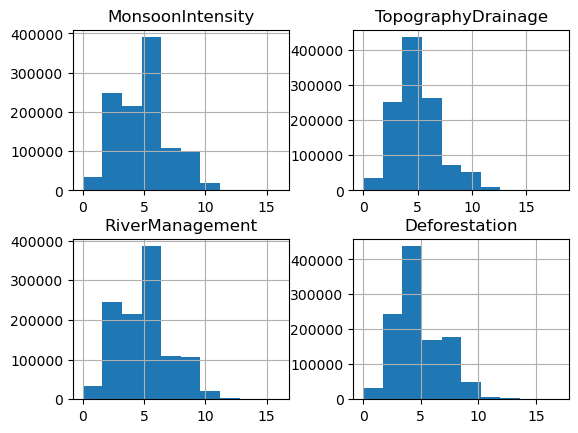

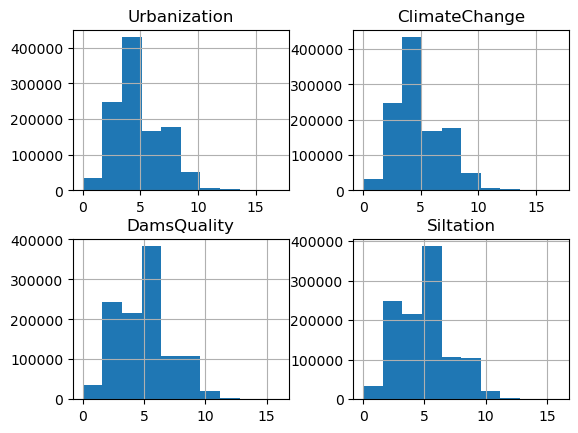

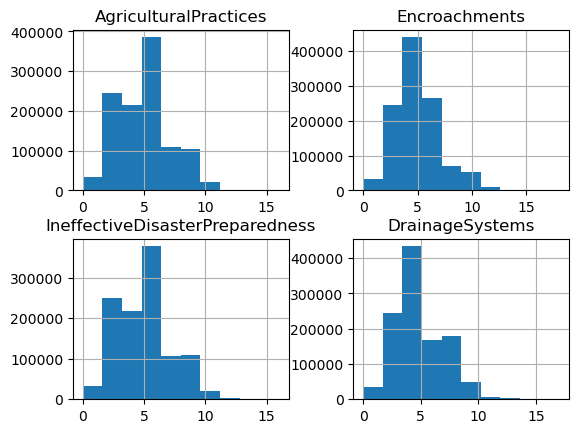

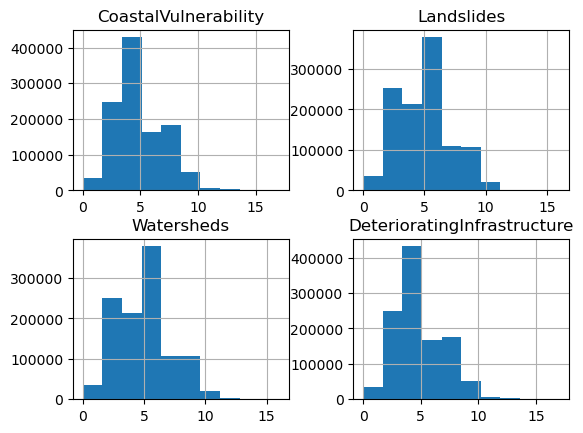

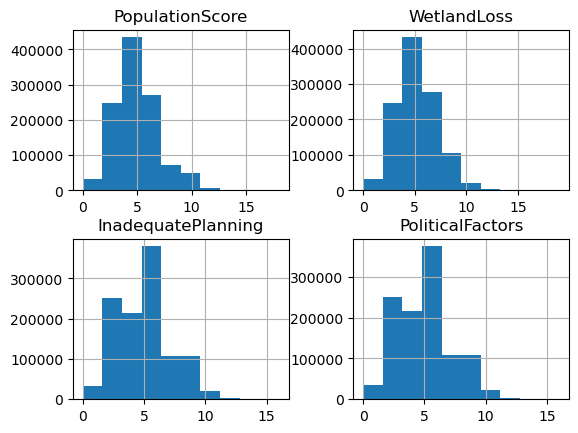

In [8]:
for col in range(5):
    train[feature[ col*4: (col+1)*4 ]].hist()
    plt.savefig(os.path.join(outPath, f'hist_{col}'))

<Axes: >

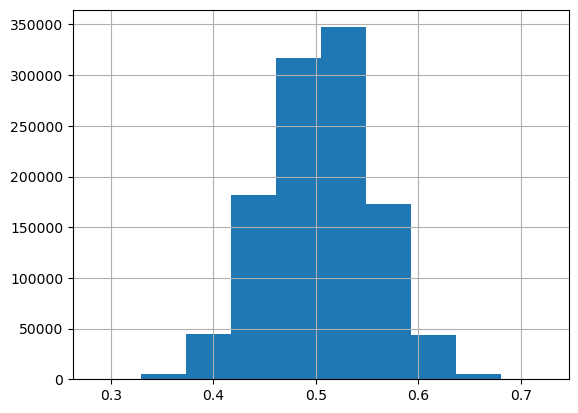

In [9]:
train['FloodProbability'].hist()

### 数据预处理

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler

full_pipeline = Pipeline([
    ('stdScaler', StandardScaler()),
    ('minmaxScaler', MinMaxScaler())
])

X_train = full_pipeline.fit_transform(train[feature])
y_train = train['FloodProbability'].to_numpy()

X_test = full_pipeline.transform(test[feature])

### 模型训练

采用逻辑回归与随机森林

In [ ]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import GridSearchCV

# lr_model = LogisticRegression()
# rf_model = RandomForestRegressor()

# param_grid_rf = {
#     'n_estimators': range(100, 200, 50),
#     'max_depth': range(10, 20, 10),
#     # 'max_leaf_nodes': range(5, 20, 10)
# }

# param_grid_lr = {
#     'max_iter': range(100, 200, 100)
# }
# score = 'r2'

# grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, 
#                             scoring=score, cv=3, n_jobs=-1)
# grid_search_lr = GridSearchCV(estimator=lr_model, param_grid=param_grid_lr, scoring=score, cv=3, n_jobs=-1)

# grid_search_rf.fit(X_train, y_train)
# grid_search_lr.fit(X_train, y_train)

# print("Random Forest Best Parameters:", grid_search_rf.best_params_)
# print("Logistic Regression Best Parameters:", grid_search_lr.best_params_)

In [ ]:
# best_params_rf = grid_search_rf.best_params_
# best_params_lr = grid_search_lr.best_params_

# rf_model_best = RandomForestRegressor(n_estimators=best_params_rf['n_estimators'], 
#                                     max_depth=best_params_rf['max_depth'], 
#                                     # max_leaf_nodes=best_params_rf['max_leaf_nodes'], 
#                                     n_jobs=-1)
# lr_model_best = LogisticRegression(max_iter=best_params_lr['max_iter'], n_jobs=-1)

# rf_model_best.fit(X_train, y_train)
# lr_model_best.fit(X_train, y_train)

In [ ]:
# rf_pred_best = rf_model_best.predict(X_test)
# lr_pred_best = lr_model_best.predict(X_test)

In [19]:
rf_model = RandomForestRegressor(n_estimators=200, max_depth=35, n_jobs=-1)

rf_model.fit(X_train, y_train)


In [20]:
# from sklearn.metrics import r2_score

# score = r2_score(y_test, y_pred_rf, multioutput='raw_values')

In [31]:
y_pred_rf = rf_model.predict(X_test)

In [35]:
sample['FloodProbability'] = y_pred_rf
outCsv(sample, 'sample_randomForest.csv')

<Axes: >

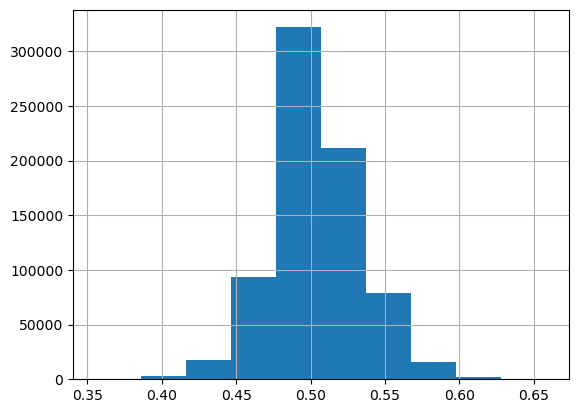

In [33]:
sample['FloodProbability'].hist()

随机森林得到 0.66287 public score

试一下线性回归？

弹性网络开始

In [12]:
param_grid_net = {
    'alpha': np.arange(0.1, 0.5, 0.1),
    'l1_ratio' : np.arange(0.1, 1, 0.1),
    'max_iter' : [500, 1000]
    }
scoreing = 'r2'

elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
gird_search_net = GridSearchCV(estimator=elastic_net, param_grid=param_grid_net,
                               scoring=scoreing, cv=3, verbose=True)
gird_search_net.fit(X_train, y_train)

print(gird_search_net.best_params_)


Fitting 3 folds for each of 72 candidates, totalling 216 fits
{'alpha': 0.1, 'l1_ratio': 0.1, 'max_iter': 500}


In [13]:
best_parm_net = gird_search_net.best_params_
elastic_net = ElasticNet(alpha=0,
                         l1_ratio=0.01)
elastic_net.fit(X_train, y_train)


d:\tool\Anconda\envs\ML\Lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
d:\tool\Anconda\envs\ML\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
d:\tool\Anconda\envs\ML\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.257e+02, tolerance: 2.911e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_d

ElasticNet(alpha=0, l1_ratio=0.01)

In [14]:
score_r2 = r2_score(y_train, elastic_net.predict(X_train), multioutput='raw_values')
print(score_r2)

[0.84495011]


In [15]:
y_pred_net = elastic_net.predict(X_test)

<Axes: >

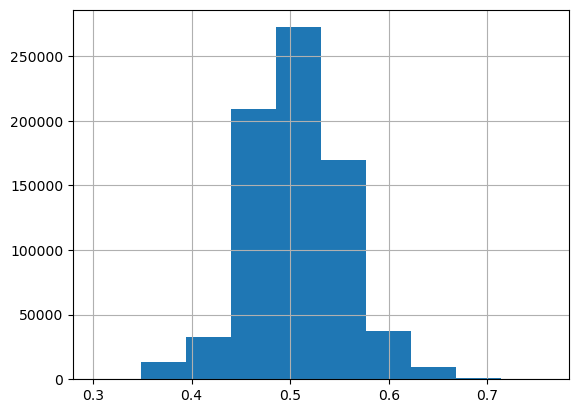

In [16]:
sample['FloodProbability'] = y_pred_net
sample['FloodProbability'].hist()

In [17]:
outCsv(sample, 'sample_Enet.csv')

可以看出网格搜索的 ``l1_ratio`` 十分接近0 (倾向于l2 penalty)，那我们为什么不试一试岭回归？

In [18]:
from sklearn.linear_model import Ridge

param_rg = {'alpha': np.arange(0.3, 1.11, 0.1),
            'solver': ['svd', 'cholesky', 'sag']}
scoreing = 'r2'

rg_model = Ridge()
grid_rg = GridSearchCV(rg_model, param_rg, scoring=scoreing, cv=5, n_jobs=4)
grid_rg.fit(X_train, y_train)

print(grid_rg.best_params_)

{'alpha': 1.0000000000000002, 'solver': 'sag'}


In [19]:
best_parm_rg = grid_rg.best_params_
rg_model = Ridge(alpha=best_parm_rg['alpha'], solver=best_parm_rg['solver'])
rg_model.fit(X_train, y_train)
print(r2_score(y_train, rg_model.predict(X_train)))

0.8449501006427806


<Axes: >

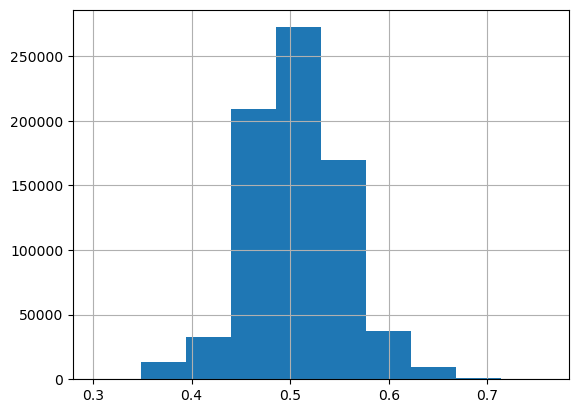

In [20]:
y_pred_rg = rg_model.predict(X_test)
sample['FloodProbability'] = y_pred_rg

sample['FloodProbability'].hist()

In [21]:
outCsv(sample, 'sample_ridge.csv')

试一下集成学习能不能提高R2分数？

先从 AdaBoost 开始

(懒得网格搜索超参了，先初步尝试一下吧)

In [23]:
from sklearn.ensemble import AdaBoostRegressor

ada_reg = AdaBoostRegressor(
    rg_model, n_estimators=100,
    loss='linear', learning_rate=0.5)

ada_reg.fit(X_train, y_train)
print(r2_score(y_train, ada_reg.predict(X_train)))
y_pred_ada = ada_reg.predict(X_test)

In [ ]:
sample['FloodProbability'] = y_pred_ada
sample['FloodProbability'].hist()

outCsv(sample, 'sample_ada.csv')